In [2]:
import numpy as np
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import Dense, Activation, Reshape, Flatten, Dropout
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.optimizers import Adam
from keras.datasets import mnist
% matplotlib inline

Using TensorFlow backend.


In [3]:
def generator():
    model = Sequential()

    model.add(Dense(units=7 * 7 * 128, input_shape=(100,)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))

    model.add(Reshape((7, 7, 128)))
    model.add(Conv2DTranspose(filters=64, kernel_size=(2, 2), strides=(2, 2)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))

    model.add(Conv2DTranspose(filters=1, kernel_size=(2, 2), strides=(2, 2)))
    model.add(Activation('tanh'))

    return model

generator().summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 6272)              633472    
_________________________________________________________________
batch_normalization_1 (Batch (None, 6272)              25088     
_________________________________________________________________
activation_1 (Activation)    (None, 6272)              0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 14, 14, 64)        32832     
_________________________________________________________________
batch_normalization_2 (Batch (None, 14, 14, 64)        256       
_________________________________________________________________
activation_2 (Activation)    (None, 14, 14, 64)        0         
__________

In [4]:
def discriminator():
    model = Sequential()
    
    model.add(Conv2D(filters=64, kernel_size=(2, 2), strides=(2, 2), input_shape=(28, 28, 1,)))
    model.add(LeakyReLU(0.2))
    
    model.add(Conv2D(filters=128, kernel_size=(2, 2), strides=(2, 2)))
    model.add(LeakyReLU(0.2))
    
    model.add(Flatten())
    model.add(Dense(256))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.5))
    
    model.add(Dense(1))
    model.add(Activation('sigmoid'))

    return model

discriminator().summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 14, 14, 64)        320       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 128)         32896     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 7, 7, 128)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 6272)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               1605888   
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 256)               0         
__________

In [5]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = (x_train[y_train == 0] - 127.5)/127.5
# for image in x_train:
#     plt.imshow(image.reshape(28, 28), cmap='gray')
#     plt.show()

epoch 1


0.499951


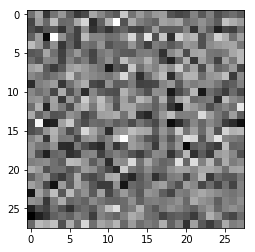

epoch 2
0.503862


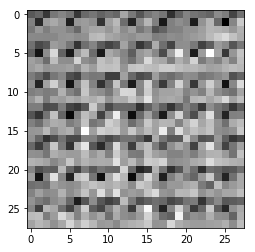

epoch 3
0.523542


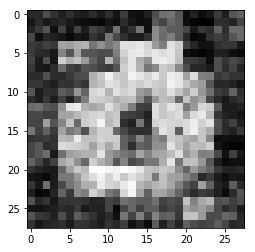

epoch 4
0.522281


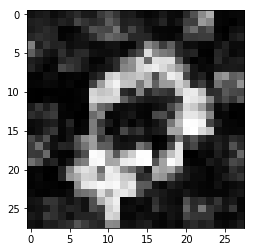

epoch 5
0.493141


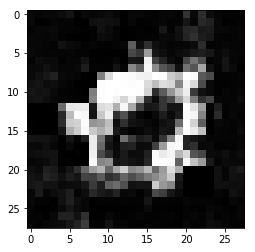

epoch 6
0.490902


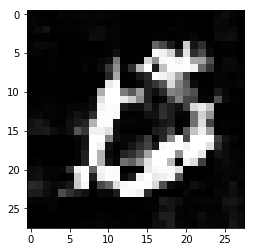

epoch 7
0.500495


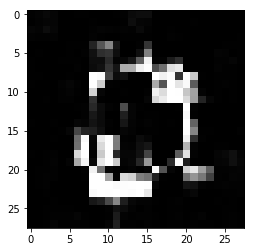

epoch 8
0.5434


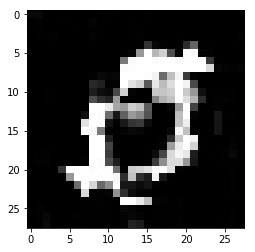

epoch 9
0.507587


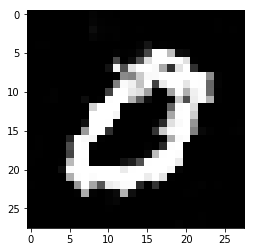

epoch 10
0.519992


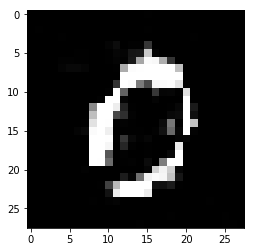

In [6]:
d = discriminator()
# d = load_model("d.h5")
d.compile(optimizer=Adam(lr=1e-5, beta_1=0.1), loss='binary_crossentropy')

g = generator()
# g = load_model("g.h5")
d.trainable = False
dcgan = Sequential([g, d])
dcgan.compile(optimizer=Adam(lr=2e-4, beta_1=0.5), loss='binary_crossentropy')

EPOCH_SIZE = 10
BATCH_SIZE = 32
Z_DIM = 100

for epoch in range(1, EPOCH_SIZE + 1):
    print(f"epoch {epoch}")
    gx = g.predict(np.random.uniform(-1, 1, size=[1, Z_DIM]), verbose=0)
    print(d.predict(gx)[0, 0])
    plt.imshow(gx.reshape(28, 28) * 175.5 + 175.5, cmap='gray')
    plt.show()

    for index in range(int(x_train.shape[0] / BATCH_SIZE)):
        gx = g.predict(np.random.uniform(-1, 1, size=[BATCH_SIZE, Z_DIM]), verbose=0)

        d_x = np.concatenate([x_train[index * BATCH_SIZE: (index + 1) * BATCH_SIZE].reshape(BATCH_SIZE, 28, 28, 1), gx])
        d_y = [1] * BATCH_SIZE + [0] * BATCH_SIZE

        d_loss = d.train_on_batch(d_x, d_y)

        g_loss = dcgan.train_on_batch(np.random.uniform(-1, 1, size=[BATCH_SIZE, Z_DIM]), [1] * BATCH_SIZE)

    d.save("d.h5")
    g.save("g.h5")